project name: hysplit_cluster_boundaries
created by diego aliaga daliaga_at_chacaltaya.edu.bo

In [19]:
try: from useful_scit.imps import *
except: pass
import pandas as pd
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt

try: import hysplit_cluster_boundaries.util as util
except: sys.path.extend(['../../'])
try: import hysplit_cluster_boundaries.util as util
except: raise ModuleNotFoundError('install hysplit_cluster_boundaries')




In [20]:
source_path = '/Users/diego/hysplit_cluster_boundaries' \
              '/hysplit_cluster_boundaries'
data_path = os.path.join(source_path, 'data')

clus_name = 'cluster_simple_6_v01.csv'
radi_name = 'long_range_radials.csv'
ring_name = 'long_range_rings.csv'

In [31]:
df_clus = pd.read_csv(os.path.join(data_path, clus_name))
df_radi = pd.read_csv(os.path.join(data_path, radi_name))
df_ring = pd.read_csv(os.path.join(data_path, ring_name))

df_clus = df_clus.sort_values(['th_in', 'r_in'])
df_clus = df_clus.set_index(['th_in', 'r_in'])
dfu = df_clus.unstack('th_in')['lab']
dfu.columns = df_radi['radials']
dfu.index = df_ring['rings']

da_clus = df_clus.to_xarray()
rad = da_clus['th_in']*0 + df_radi['radials']
rad.name = 'radials'
da_clus=da_clus.assign_coords(radials=rad)

ring = da_clus['r_in']*0 + df_ring['rings']
ring.name = 'rings'
da_clus=da_clus.assign_coords(rings=ring)

da_clus

<xarray.Dataset>
Dimensions:  (r_in: 52, th_in: 36)
Coordinates:
  * th_in    (th_in) int64 1 2 3 4 5 6 7 8 9 10 ... 28 29 30 31 32 33 34 35 36
  * r_in     (r_in) int64 1 2 3 4 5 6 7 8 9 10 ... 43 44 45 46 47 48 49 50 51 52
    radials  (th_in) float64 -3.054 -2.88 -2.705 -2.531 ... 2.705 2.88 3.054
    rings    (r_in) float64 0.0 0.02 0.02349 0.02759 ... 38.43 45.14 53.02 62.27
Data variables:
    lab      (th_in, r_in) float64 4.0 5.0 5.0 5.0 5.0 ... nan nan nan nan nan
    w        (th_in, r_in) float64 2.603e+03 6.806e+03 1.21e+04 ... nan nan nan

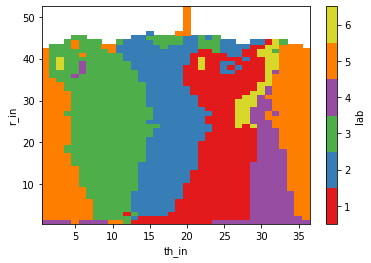

In [32]:
da_clus['lab'].plot(x='th_in', y='r_in',
                    cmap=util.ccmap, vmin=.5, vmax=6.5)
plt.show()

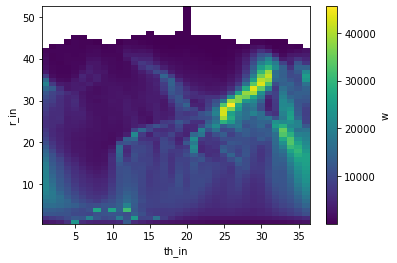

In [33]:
da_clus['w'].plot(x='th_in', y='r_in')
plt.show()

In [34]:
lat = util.r_th_to_lat(da_clus['rings'], da_clus['radials'])
lon = util.r_th_to_lon(da_clus['rings'], da_clus['radials'])

da_clus = da_clus.assign_coords(lat=lat)
da_clus = da_clus.assign_coords(lon=lon)

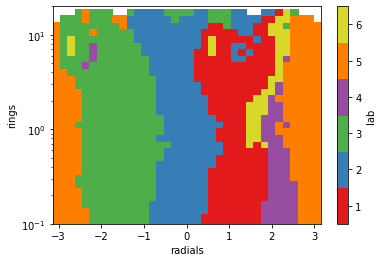

In [36]:
da_clus['lab'].plot(
    x='radials', y='rings',
    cmap=util.ccmap, vmin=.5, vmax=6.5,
    yscale='log', ylim=(.1, 20)
)
plt.show()
da_clus = da_clus.swap_dims({'r_in':'rings'})
da_clus = da_clus.loc[{'rings':slice(.05,20)}]
da_clus = da_clus.swap_dims({'rings':'r_in'})

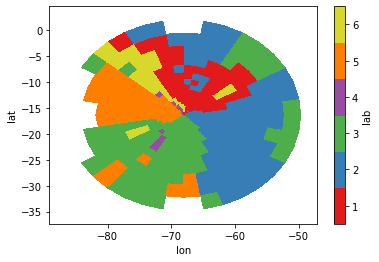

In [38]:
ll_range = 21
lo_min = util.CHC_LON - ll_range
lo_max = util.CHC_LON + ll_range
la_min = util.CHC_LAT - ll_range
la_max = util.CHC_LAT + ll_range

da_clus['lab'].plot(
    x='lon', y='lat',
    cmap=util.ccmap, vmin=.5, vmax=6.5,
    xlim=(lo_min, lo_max),
    ylim=(la_min, la_max),
)
plt.show()

In [39]:
df_out = da_clus.to_dataframe()

In [40]:
df_out

lab           w  radials      rings        lat        lon
r_in th_in                                                           
8    1      5.0  20135.5000 -3.05433   0.052508 -16.355003 -68.183643
     2      5.0  18317.8000 -2.87979   0.052508 -16.364017 -68.182053
     3      5.0  14839.3000 -2.70526   0.052508 -16.372618 -68.178923
     4      5.0  11900.1000 -2.53073   0.052508 -16.380544 -68.174347
     5      5.0   9655.5800 -2.35619   0.052508 -16.387556 -68.168463
...         ...         ...      ...        ...        ...        ...
44   32     6.0     21.8331  2.35619  17.193700  -4.192591 -80.289062
     33     3.0     23.0000  2.53073  17.193700  -6.488562 -82.215615
     34     NaN         NaN  2.70526  17.193700  -9.084050 -83.714117
     35     NaN         NaN  2.87979  17.193700 -11.900316 -84.739159
     36     NaN         NaN  3.05433  17.193700 -14.851963 -85.259613

[1332 rows x 6 columns]

In [41]:
data_out = os.path.join(source_path,'data_out')

da_clus.to_netcdf(os.path.join(data_out,'lab_weight_lat_lon_info.nc'))

labs_out = ['radials','rings','lat','lon','w','lab']
for l in labs_out:
    df_lab = df_out[l].unstack('th_in')
    df_lab.index.name = 'r|th'
    df_lab.to_csv(os.path.join(data_out,l+'.csv'))